In [1]:
import numpy as np
from hamming_distance_distribution import hamming_distance_distribution
import matplotlib.pyplot as plt
import time

In [2]:
# --------- Parameters ---------
N_repeat = 100      # how many samples per neglection thresold

N = 5               # number of users
M = 4               # length of id-sequence for every user
K = 100              # number of antennas
xi = 0              # std of thermal noise

which_ctl_fct = 0   # 0: linear control function, 1: optimal control function
N_thres = 50        # how many different neglection thresolds between 0 and 1

nb_pts_gap = 20     # number of points for the gap computation
nb_pts_time = 30    # number of points for resolution of the time dependant Schrodinger's equation
epsilon = 0.1       # precision level for the control function (valid for both, linear and optimal scheduling)
gamma = 1           # strength of the transverse field, irrelevant for us 


# runtime for these settings
T_hdd = 90       # in seconds

In [3]:
# ----------- Program -----------
print(f"Estimated runtime of the program: {(T_hdd*N_thres)/60} min.")

# activity pattern
alpha = np.zeros(N)
alpha[0] = 1
alpha[2] = 1

# iterating over the neglection thresolds
neglection_thres = np.linspace(0, 1, N_thres)

d = np.arange(N)                        # hamming distance (x-axis)
n = np.zeros(shape=(N_thres, N+1))      # number of occurences of that hamming distance
N_n = np.zeros(N_thres)            # how many matrix elements were neglected
runtime_hdd = np.zeros(N_thres)
connected_counter = np.zeros(N_thres)

for i in range(N_thres):
    t0 = time.time()
    distr = hamming_distance_distribution(N_repeat, N, M, alpha, K, xi, 1, neglection_thres[i], gamma, epsilon, which_ctl_fct, nb_pts_gap, nb_pts_time, False)
    t1 = time.time()
    runtime_hdd[i] = t1-t0

    n[i] = distr[1]
    N_n[i] = distr[2]
    connected_counter[i] = distr[3]


Estimated runtime of the program: 75.0 min.


/home/fabian/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : QuTip has not converged
Error : 

The function hamming_distance_distribution has with the selected settings an average runtime of (88.021 +- 11.957)s.
Note: in approx. 6% of cases, QuTip does not converge.


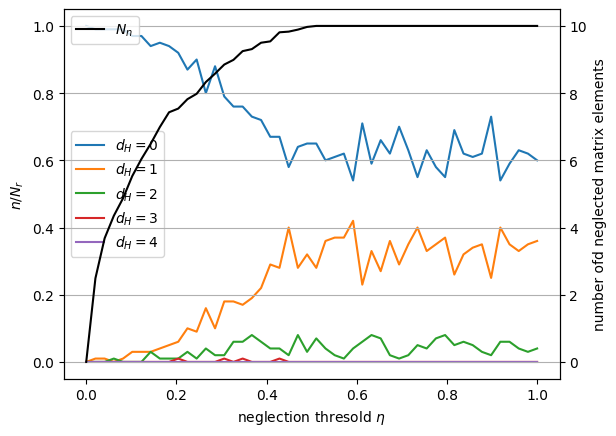

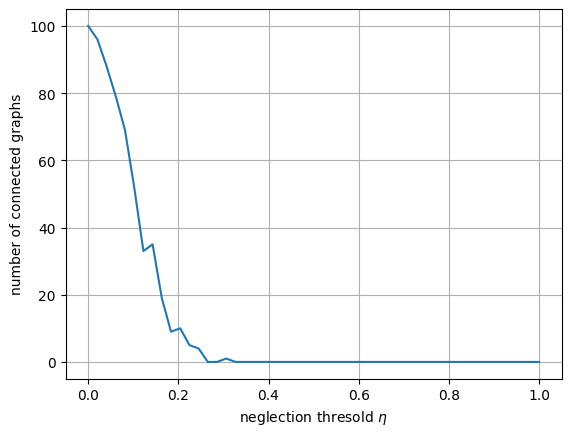

In [9]:
print(f"The function hamming_distance_distribution has with the selected settings an average runtime of ({np.mean(runtime_hdd):.3f} +- {np.std(runtime_hdd):.3f})s.")
print("Note: in approx. 6% of cases, QuTip does not converge.")

# ---------- Plotting ----------
# Hamming distances
fig = plt.figure()
axl = fig.add_subplot()
axr = axl.twinx()


for j in range(N):
    axl.plot(neglection_thres, n[:, j]/N_repeat, label=rf"$d_H={d[j]}$")
axl.set_xlabel(r"neglection thresold $\eta$")
axl.set_ylabel(r"$n/N_r$")
axl.legend()

axr.plot(neglection_thres, N_n, label=r"$N_n$", color="black")
axr.set_ylabel("number ofd neglected matrix elements")
axr.legend()

plt.legend()
plt.grid()
plt.show()


plt.plot(neglection_thres, connected_counter)
plt.xlabel(r"neglection thresold $\eta$")
plt.ylabel("number of connected graphs")
plt.grid()
plt.show()